# Problem 1 (Value iteration)

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

In this assignment, you will be implementing a value iteration algorithm

In [1]:
import gym
import numpy as np
print("numpy version", np.__version__)
print("gym version", gym.__version__)

numpy version 1.25.2
gym version 0.25.0


In [2]:
env=gym.make('FrozenLake-v1')

/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
## DO NOT CHANGE THIS CELL

def argmax(env, V, pi, action, s, gamma):
    e = np.zeros(env.action_space.n)
    for a in range(env.action_space.n): # iterate for every action possible
        q = 0
        P = env.P[s][a]
        for prob, next_state, reward, done in P:    # iterate for every possible states
            q += prob * (reward + gamma * V[next_state])    # calculate action_ value q(s|a)
        e[a] = q

    m = np.argmax(e)
    action[s] = m   # Take index which has maximum value 
    pi[s][m] = 1    # update pi(a|s) 

    return pi

Your task is to complete the "bellman_opt_update" function below, which servces as a subroutine for the value iteration method.

In [4]:
def bellman_opt_update(env, V, s, gamma): # update the state_value V[s]
    e = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        val = 0
        P = env.P[s][a]
        for prob, next_state, reward, done in P:
            val += prob * (reward + gamma * V[next_state])
        e[a] = val

    V[s] = np.max(e)

In [5]:
def value_iteration(env, gamma, theta):
    V = np.zeros(env.observation_space.n)   # initialize v(0) to arbitory value, my case "zeros"
    while True:
        delta = 0
        for s in range(env.observation_space.n):    # iterate for all states
            v = V[s]
            bellman_opt_update(env, V, s, gamma)    # update state_value with bellman optimality update
            delta = max(delta, abs(v - V[s]))   # assign the change in value per iteration to delta  
        if delta < theta:
            break   # if change gets to negligible --> converged to optimal value

    pi = np.zeros((env.observation_space.n, env.action_space.n))
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = argmax(env, V, pi, action, s, gamma)   # extract optimal policy using action value 

    return V, pi, action     # optimal value funtion, optimal policy with one-hot encoding (pi), optimal policy with discrete number (action)

In [6]:
## DO NOT CHANGE THIS CELL

gamma = 0.99
theta = 0.000001

env.reset(seed=1)
V, pi, action = value_iteration(env, gamma, theta) # note "action" is optimal policy with discrete action number

#initialize episodic structure
num_episodes=1000;
episode_max_length=10000;

e=0
for i_episode in range(num_episodes):
    s = env.reset()
    for t in range(episode_max_length):
        s, reward, done, _ = env.step(action[s])
        if done:
            if reward == 1:
                e +=1
            break
print(" agent succeeded to reach goal {} out of {} Episodes using this policy ".format(e+1, num_episodes))
print(" success rate:", (e+1)/num_episodes)
env.close()

/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


 agent succeeded to reach goal 741 out of 1000 Episodes using this policy 
 success rate: 0.741


# Problem 2 (Q-learning)

For proper accounting rewards while you learn, we build a wrapper around env.step() and env.reset(). In an episode, every time you take an action the reward will be appended to the reward of the episode, and when ever the environment is reset (at the end of an epsiode), the episode reward is reset to 0. 

In [7]:
## DO NOT CHANGE THIS CELL
#wrapper for accounting rewards
rEpisode=0
rList=[]

def reset_decorate(func):
    def func_wrapper():
        global rList
        global rEpisode
        rList.append(rEpisode)
        rEpisode=0
        return(func())
    return func_wrapper

env.reset = reset_decorate(env.reset)

def step_decorate(func):
    def func_wrapper(action):
        global rEpisode
        s1, r, d, other = func(action)
        rEpisode+=r
        return(s1, r, d, other)
    return func_wrapper

env.step = step_decorate(env.step)

def init():
    rEpisode=0
    rList=[]
    return;

In [8]:
## DO NOT CHANGE THIS CELL
# PLOTTING functions
from numpy import convolve, ones
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')
from pylab import plot
%matplotlib inline 

Below we illustrate the execution of the Open AI gym enviornment using the policy of chosing random action in every state. Every time an action is taken the enviorment returns a tuple containing next state, reward, and the status (whether terminal state is reached or not). 

/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


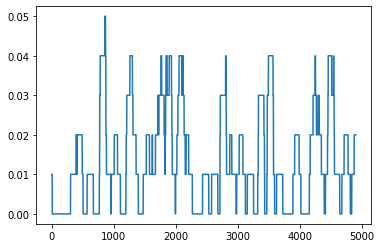

In [9]:
## DO NOT CHANGE THIS CELL
### RANDOM SAMPLING EXAMPLE
num_episodes=5000; #number of episodes you want to try
episode_max_length=100; #you can explicitly end the epsiode before terminal state is reached

env.seed(123)
#env.render()
#execute in episodes
for i in range(num_episodes):
    d = False #not done
    #rFinal=0
    for t in range(episode_max_length):
        
        ################ Random action policy ###########################
        #play random action 
        a = env.action_space.sample()
        #get new state, reward, done
        s, r, d, _ = env.step(a)
        #################################################################
        
        
        #break if done, reached terminal state 
        if d == True:
            break
    #reset the environment for the next episode
    s = env.reset()

rm=movingaverage(rList, 100)
plot(rm)
rEpisode=0
rList=[]

Implement tabular Q-learning (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [19]:
## CHANGE THIS CELL BY YOURSELF
###ALWAYS DO RUN ALL CELLS, otherwise some structures may not get initialized properly
rEpisode=0
rList=[]

#initialize episodic structure
num_episodes=5000;
episode_max_length=100;

#initialize discount factor, learning rate
gamma=0.95
learnRate=0.8

## Epsilon greedy
eps = 0.9
eps_decay = 0.99
##

env.seed(111)

#create Q table
Q=np.zeros([env.observation_space.n,env.action_space.n]) #matrix Q[s,a]

#execute in episodes
for i in range(num_episodes):
    
    #reset the environment at the beginning of an episode
    s = env.reset()
    d = False #not done
    
    for t in range(episode_max_length):
        
        ###########SELCT ACTION a for state s using Q-values ##################
        # e-greedy action
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s, :]) 

        #get new state, reward, done
        s1, r, d, _ = env.step(a)
        
        ##### update Q(s,a) ############
        ## Q-learning update: Bellman Optimal Equation update
        Q[s][a] = Q[s][a] + learnRate*(r + gamma*np.max(Q[s1, :]) - Q[s][a])
        
        #break if done, reached terminal state 
        if d == True:
            break
        s=s1
    
    eps = eps * eps_decay

/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


plot moving average over 100 episodes

Solved after 1584 episodes.


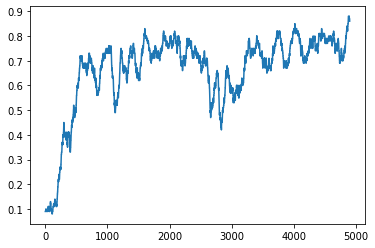

In [20]:
## DO NOT CHANGE THIS CELL
rm=movingaverage(rList, 100)
plot(rm)
criterion = len(np.where(rm >= .78)[0]) >0
if criterion:
    print("Solved after %d episodes." % np.where(rm >= .78)[0][0])
else:
    print("Unsolved Yet!")

# Problem 3 (SARSA)
Implement tabular SARSA (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [12]:
env.seed(123)

# Number of episodes and other hyperparameters
num_episodes = 5000
episode_max_length = 100
gamma = 0.95
learn_rate = 0.8
eps = 0.9
eps_decay = 0.99

# Create Q-table for FrozenLake-v1
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Execute in episodes
for i in range(num_episodes):
    # Reset the environment at the beginning of an episode
    s = env.reset()
    d = False  # Not done

    ########### SELECT ACTION a for state  using current policy ##################
    ## Take an action at state s by e-greedy policy
    if np.random.rand() < eps:
        a = env.action_space.sample()
    else:
        a = np.argmax(Q[s, :])
        
    for t in range(episode_max_length):

        # Get new state, reward, done
        s1, r, d, _ = env.step(a)

        ##### Update Q(s,a) ############
        ## Take an action at state s1 by e-greedy policy
        if np.random.rand() < eps:
            a1 = env.action_space.sample()
        else:
            a1 = np.argmax(Q[s1, :])

        ## SARSA Update
        Q[s][a] = Q[s][a] + learn_rate * (r + gamma * Q[s1][a1] - Q[s][a])

        # Break if done, reached a terminal state
        if d:
            break
        s, a = s1, a1

    # Epsilon decay
    eps = eps * eps_decay

    # Policy improvement
    pi = np.argmax(Q, axis=1)

/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Solved after 3356 episodes.


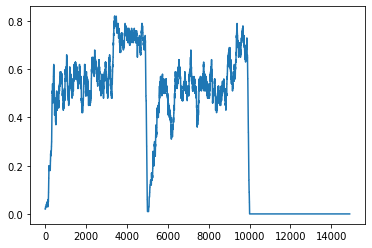

In [26]:
## DO NOT CHANGE THIS CELL
rm=movingaverage(rList, 100)
plot(rm)
criterion = len(np.where(rm >= .78)[0]) >0
if criterion:
    print("Solved after %d episodes." % np.where(rm >= .78)[0][0])
else:
    print("Unsolved Yet!")

# Problem 4 (Dyna-Q)

In [14]:
import time
from matplotlib import pyplot as plt

In [15]:
class Agent():
    def __init__(self, env, total_episodes, step_limit, epsilon, epsilon_decay,
                 min_epsilon, gamma, alpha, alpha_decay, min_alpha):
        self.env = env
        self.action_space = env.action_space.n
        self.observation_space = env.observation_space.n
        self.qtable = np.zeros((self.observation_space, self.action_space))
        self.total_rewards = []
        self.total_steps = []
        self.total_episodes = total_episodes
        self.step_limit = step_limit
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.min_alpha = min_alpha
    
    def alpha_schedule(self, episode):
        if (episode + 1) % 1000 == 0:
            self.alpha *= self.alpha * self.alpha_decay
            self.alpha = max(self.alpha, self.min_alpha)
    
    def epsilon_schedule(self, episode):
        if (episode + 1) % 1000 == 0:
            self.epsilon *= self.epsilon * self.epsilon_decay
            self.epsilon = max(self.epsilon, self.min_epsilon)
    
    def learn(self, state_old, state_new, reward, action):
        prediction = self.qtable[state_old, action]
        target = reward + self.gamma * np.max(self.qtable[state_new, :])
        self.qtable[state_old, action] = self.qtable[state_old, action] + self.alpha * (target - prediction)
    
    def choose_action(self, state):
        action = 0
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.qtable[state, :])
        return action
    
    def train(self):
        episode_print_split = self.total_episodes // 5
        for episode in range(self.total_episodes):
            state = self.env.reset()
            t = 0
            done = False
            self.alpha_schedule(episode)
            self.epsilon_schedule(episode)
            for t in range(step_limit):
                action = self.choose_action(state)
                state_new, reward, done, info = self.env.step(action)
                self.learn(state, state_new, reward, action)
                state = state_new
                t += 1
                if done:
                    self.total_rewards.append(reward)
                    self.total_steps.append(t)
                    if (episode + 1) % episode_print_split == 0:
                        if reward > 0.0:
                            outcome = 'win'
                        else:
                            outcome = 'lose'
                        print(f'Episode {episode} | {t} steps | {outcome}')
                    break
        print('')
        total_win_rate = sum(self.total_rewards) / self.total_episodes
        print(f'Total win rate {total_win_rate}')

    def moving_average(self, window):
        weights = np.repeat(1.0, window) / window
        simple_moving_average = np.convolve(self.total_rewards, weights, 'valid')
        return simple_moving_average

In [16]:
total_episodes = 100000
step_limit = 100 # max steps per episode
epsilon = 1
epsilon_decay = 0.2
min_epsilon = 1e-4
gamma = 0.95
alpha = .8
alpha_decay = 0.3
min_alpha = 1e-4

env = gym.make('FrozenLake-v1')
frozenlake = Agent(env, total_episodes, step_limit, epsilon, epsilon_decay,
                 min_epsilon, gamma, alpha, alpha_decay, min_alpha)
frozenlake.train()

/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/wooseong/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 19999 | 18 steps | win
Episode 39999 | 20 steps | win
Episode 59999 | 58 steps | win
Episode 79999 | 100 steps | lose
Episode 99999 | 20 steps | win

Total win rate 0.71163


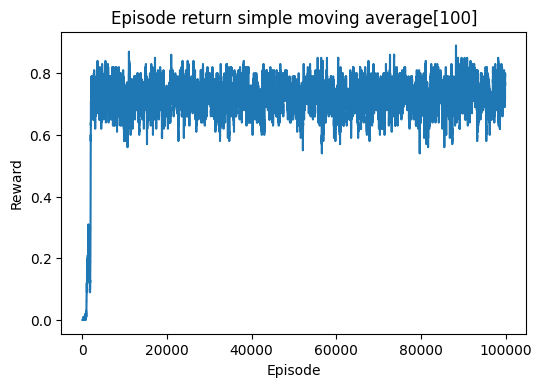

In [17]:
window = 100
average_reward = frozenlake.moving_average(window)

plt.figure(dpi = 100)
plt.title(f'Episode return simple moving average[{window}]')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.plot(average_reward)